In [2]:
import torch
from glob import glob
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

In [3]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use('dark_background')

display(HTML("<style>"
    + "#notebook { padding-top:0px; } " ""
    + ".container { width:100%; } "
    + ".end_space { min-height:0px; } "
    + "</style>"))

In [68]:
def print_exp_info(exp: dict):
    print(f'model: {exp["model"]} {exp["approach"]}')
    print({k: exp[k] for k in exp if k not in ['logs', 'results', 'knowledge']})

# usage example:  show_exp_images(experiments[0], True)
def show_exp_images(exp: dict, show_origins=False):
    for task in exp['results']:
        cur_images = exp['results'][task]['images']
        fig, axs = plt.subplots(2, 5, figsize=(15, 8))
        fig.suptitle(f'TASK {task} {exp["knowledge"][task]}', fontsize=30)
        for r, row in enumerate(axs):
            for c, cell in enumerate(row):
                idx = r*5 + c
                image = np.zeros((28, 28, 3), dtype=float)
                cell.set_title(cur_images[idx]['label'])
                orig = np.array(cur_images[idx]['original'][0])
                recon = np.array(cur_images[idx]['reconstruction'][0]).clip(0, 1)
                if show_origins:
                    image[:,:,1] = orig
                image[:,:,0] = recon
                image[:,:,2] = recon
                cell.imshow(image)
        plt.show()

In [52]:
def calc_D_L_torch(data: torch.Tensor, sigma=1.):
    dist_matrix = ((data[None, ...] - data.unsqueeze(1)) ** 2).sum(-1)
    # compute affinity matrix
    A = torch.exp(-dist_matrix / (sigma ** 2))

    # compute degree matrix
    D = torch.diag(A.sum(1))
    # compute laplacian
    L = D - A
    return A, D, L

def find_eig_torch(laplacian: torch.Tensor):
    eigenvalues, eigenvectors = torch.linalg.eig(laplacian)
    eigenvalues = eigenvalues.to(float)
    eigenvectors = eigenvectors.to(float)
    sorted_indices = torch.argsort(eigenvalues)
    eigenvalues, eigenvectors = eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]
#     print(eigenvalues,'\n'*2 ,eigenvectors)
    return eigenvalues, eigenvectors

def normalize_A_torch(a_m, d_m):
    return torch.sqrt(torch.linalg.inv(d_m))@a_m@torch.sqrt(torch.linalg.inv(d_m))

def dir_energy(data: torch.Tensor):
    A, D, L = calc_D_L_torch(data)
    eigenvalues, eigenvectors = find_eig_torch(L)
    nsamples = len(data)
    max_value = nsamples * (nsamples - 1)
    dir_energy = eigenvalues.sum()
    energy_p = dir_energy / max_value
    return energy_p.cpu().item()

def dir_energy_normal(data: torch.Tensor):
    A, D, L = calc_D_L_torch(data)
    L_norm = torch.eye(A.shape[0]).to('cuda')-normalize_A_torch(A, D)
    eigenvalues, eigenvectors = find_eig_torch(L_norm)
    nsamples = len(data)
    max_value = nsamples - 1
    dir_energy = eigenvalues.sum()
    energy_p = dir_energy / max_value
    return energy_p.cpu().item()

def flatten_list(l: list[list[any]]) -> list[any]:
    return [item for line in l for item in line]

In [5]:
logs_path = 'C:\\Users\\emace\\AImageLab\\SRV-Continual\\results\\canomaly\\logs'

In [6]:
exp_dict = {}
environments = []
for log_file in glob(logs_path + '/**rec**/*.pyd', recursive=True):
    print(log_file)
    with open(log_file, 'r') as f:
        props_list = [prop.split('-', 1) for prop in log_file.replace(logs_path, '').split('\\')[1:-1]]
        props = {prop[0]: prop[1] for prop in props_list}
        exps = []
        for i, line in enumerate(f.readlines()):
            try:
                exps.append(literal_eval(line.replace('nan', 'None')))
            except:
                print(f'Unparsed line {i}:\n\t{exps[:-1]}\n-->\t{line}')

        environments.append({'env': props, 'exps': exps})

        exps = {exp['id']: exp for exp in exps}
        exp_dict = {**exp_dict, **exps}

C:\Users\emace\AImageLab\SRV-Continual\results\canomaly\logs\dataset-rec-fmnist\logs.pyd


In [83]:
exp_list = environments[0]['exps']

In [81]:
def show_exp_energies(exp: dict):
    print_exp_info(exp)

    for task_id in exp['results']:
        task_idx = int(task_id)
        task = exp['results'][task_id]
        targets = torch.tensor(task['targets'], device='cuda')
        latents = torch.tensor(task['latents'], device='cuda')
        knowledge = [k for k in exp['knowledge'].values()]
        for i in range(1, len(knowledge)):
            knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:1])]

        cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
        past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
        fut_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[task_idx:]))]

        print(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})\n'
              f'current:        energy {dir_energy(cur_latents):.4f}     \tmean {cur_latents.mean():.3f} ± {cur_latents.std():.3f}\n'
              f'with past:      energy {dir_energy(past_latents):.4f}    \tmean {past_latents.mean():.3f} ± {past_latents.std():.3f}\n'
              f'with future:    energy {dir_energy(fut_latents):.4f}     \tmean {fut_latents.mean():.3f} ± {fut_latents.std():.3f}\n'
              f'total:          energy {dir_energy(latents):.4f}         \tmean {latents.mean():.3f} ± {latents.std():.3f}')

In [82]:
for exp in environments[0]['exps']:
    show_exp_energies(exp)

model: rec-vae continual
{'seed': 4070909266, 'wandb': False, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'sgd', 'lr': 0.1, 'scheduler_steps': 0, 'scheduler_gamma': 0.1, 'approach': 'continual', 'batch_size': 64, 'n_epochs': 10, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': False, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'id': '4f8c857e-2a64-4fba-a718-599cbe85fa27', 'timestamp': '2022-03-07 14:49:14.754408'}
0. Task 0 ([0, 2, 3, 4, 6])
current:        energy 0.7493     	mean 0.002 ± 0.069
with past:      energy 0.7493    	mean 0.002 ± 0.069
with future:    energy 0.7202     	mean 0.006 ± 0.076
total:          energy 0.7202         	mean 0.006 ± 0.076
1. Task 1 ([1])
current:        energy 0.8702     	mean 0.000 ± 0.048
with past:      energy 0.6955    	mean 0.026 ± 0.093
with future:    energy 0.6942     	mean 0.025 ± 0.090
total:          energy 0.6631         	mean 0.028 ± 0.095
2. Task 2 ([5, 7, 9])
curren

model: rec-ae continual
{'seed': 1039709243, 'wandb': False, 'dataset': 'rec-fmnist', 'model': 'rec-ae', 'optim': 'sgd', 'lr': 0.1, 'scheduler_steps': 0, 'scheduler_gamma': 0.1, 'approach': 'continual', 'batch_size': 64, 'n_epochs': 10, 'latent_space': 32, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'id': '7c903588-674f-4e88-9bb8-ee863b5b8d74', 'timestamp': '2022-03-07 15:17:24.686891'}


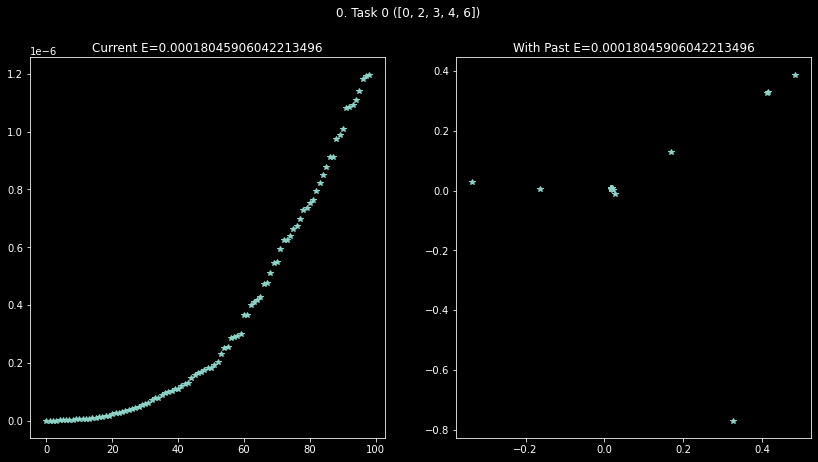

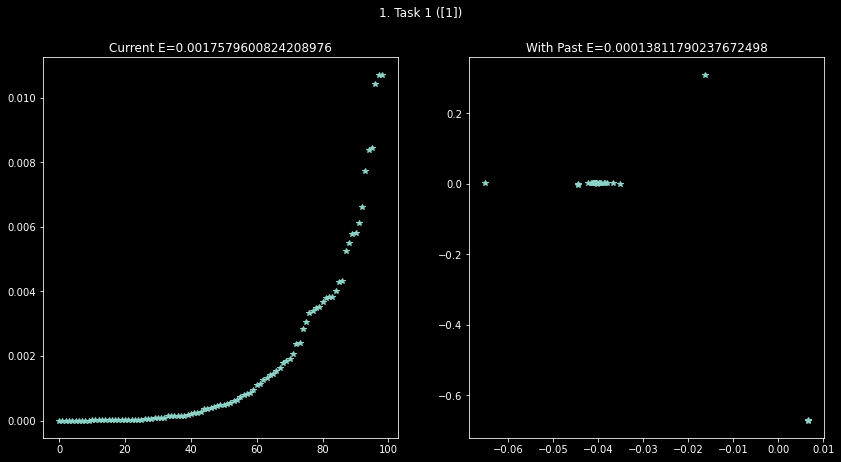

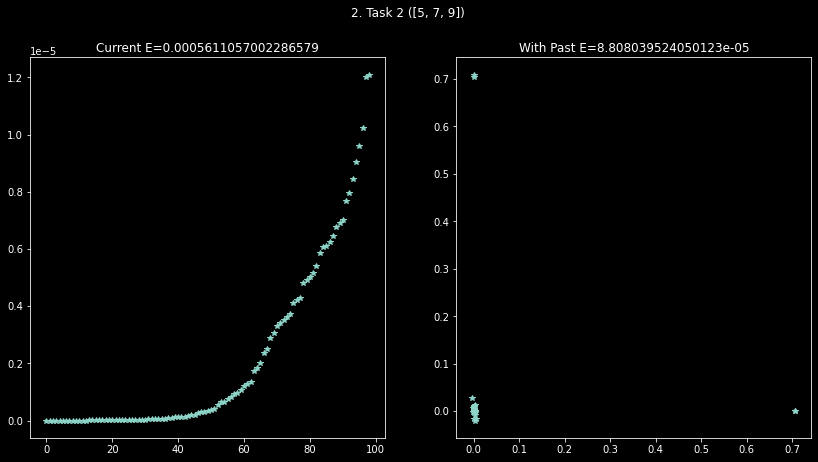

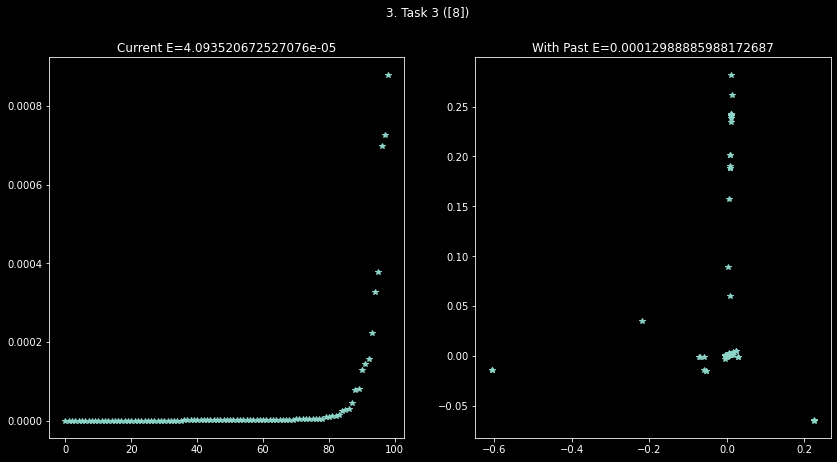

In [106]:
exp = exp_list[2]

print_exp_info(exp)
figsize = (14, 7)
limit = 100

for task_id in exp['results']:
    task_idx = int(task_id)
    task = exp['results'][task_id]
    targets = torch.tensor(task['targets'], device='cuda')
    latents = torch.tensor(task['latents'], device='cuda')
    knowledge = [k for k in exp['knowledge'].values()]
    for i in range(1, len(knowledge)):
        knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:1])]

    cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
    past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
    fut_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[task_idx:]))]

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    A, D, L = calc_D_L_torch(cur_latents)
    eigenvalues, eigenvectors = find_eig_torch(L)
    eigenvalues /= len(cur_latents)
    ax[0].plot(eigenvalues[1:limit].cpu(), '*')
    ax[0].set_title(f'Current E={dir_energy(cur_latents)}')

    A, D, L = calc_D_L_torch(past_latents)
    eigenvalues, eigenvectors = find_eig_torch(L)
    eigenvalues /= len(past_latents)
    # ax[1].plot(eigenvalues[1:limit].cpu(), '*')
    ax[1].plot(eigenvectors[:, 1].cpu(), eigenvectors[:, 2].cpu(), '*')
    ax[1].set_title(f'With Past E={dir_energy(past_latents)}')

    plt.suptitle(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})')
    plt.show()

In [31]:
useless_cols = ['seed', 'logs', 'timestamp']
# cols without duplicates
model_cols = {
    'common_pre': ['n_epochs', 'batch_size', 'optim', 'lr', 'model'],
    'ae': ['latent_space'],
    'dae': ['noise_mean', 'noise_std'],
    'sae': ['sparse_weight', 'norm_order'],
    'vae': ['kl_weight', 'beta_kl', 'forward_sample'],
    'common_post': ['approach', ['id']]
}
result_cols = ['results', 'knowledge']

group_cols = [col for cols in model_cols for col in model_cols[cols]]
order_cols = group_cols + result_cols

methods_list = []
def method_id(df: pd.DataFrame):
    idx = len(methods_list)
    methods_list.append({'exps': list(df)})
    return idx

for env in environments:
    env_cols = [prop for prop in env['env']]

    results = pd.DataFrame.from_records(env['exps'])
    tot_cols = results.columns.tolist()
    exclude_cols = [col for col in useless_cols + env_cols if col in tot_cols]
    orderby_cols = [col for col in order_cols if col in tot_cols]
    groupby_cols = [col for col in group_cols if col in tot_cols]
    unknown_cols = [col for col in tot_cols if col not in exclude_cols + orderby_cols]
    env['unknown'] = unknown_cols
    results = results[orderby_cols]
    results['runs'] = 1
    results = results.groupby(groupby_cols, dropna=False).agg(
        {'runs': 'count', 'id': method_id, **{res: ['mean', 'std'] for res in result_cols}}
    )
    for index, res in results.iterrows():
        id_met = int(res[('id', 'method_id')])
        methods_list[id_met]['props'] = {name: index[i] for i, name in enumerate(results.index.names)}
        methods_list[id_met]['env'] = env['env']
        methods_list[id_met]['results'] = {res_col: {'mean': res[(res_col, 'mean')], 'std': res[(res_col, 'std')]} for res_col in result_cols}

    env['results'] = results

sort = False
sort_col = ('auc_final', 'mean')
for env in environments:
    print('ENV INFO - ' + str(env['env']))
    if len(env['unknown']):
        print('-- unknown props: ' + str(env['unknown']))
    display(env['results'].sort_values(sort_col, ascending=False) if sort else env['results'])
    print('-'*100 + '\n')

